## CSUS - CSc 177-02 Data Warehousing and Data Mining - Project 1: Clustering  
### 2016 U.S. presidential election Twitter analysis  

**Group members: Aaron Enberg, Nima Sarrafzadeh, Kyne Liu**  
**Professor: Haiquan (Victor) Chen**

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    preprocessing,  
    cluster as sk_cluster,
    metrics
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV
)
import sklearn.feature_extraction.text as sk_text
import gc

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [237]:
column_names = ['name', 'screen_name', 'user_id', 
                'followers_count', 'friends_count', 
                'location', 'description', 'created_at', 
                'status_id', 'language', 'place', 
                'retweet_count', 'favorite_count', 'text']

tweets = pd.read_table('data/clinton_trump_tweets.txt', names=column_names, encoding='ISO-8859-1')

In [238]:
print(tweets.shape)
print(tweets.dtypes)

(5250980, 14)
name               object
screen_name        object
user_id            int64 
followers_count    int64 
friends_count      int64 
location           object
description        object
created_at         object
status_id          int64 
language           object
place              object
retweet_count      int64 
favorite_count     int64 
text               object
dtype: object


## Preprocessing

In [239]:
tweets.drop(['name', 'screen_name', 
            'followers_count', 
            'friends_count', 
            'location', 
            'description', 
            'created_at',
            'status_id', 
            'language', 
            'place', 
            'retweet_count', 
            'favorite_count'], axis=1, inplace=True)
tweets.head()

,user_id,text
0,1519696717,@NWAJimmy I've read it now though brother. Was pretty spot on Lots of bright spots but a lot to work on. Exactly as an exhibition should be!
1,109945090,RT @wikileaks: New poll puts Pirate Party on course to win Iceland's national elections on Saturday. https://t.co/edTqjeJaQ6
2,1450086582,@gaystoner821 I think New Orleans spoiled me with food. I need to try and branch out in BR.
3,167177185,RT @LOLGOP: ACA needs fixes but know da facts: *70% can get covered in marketplaces for under $75/month *Hikes affect 3% *GOP will uninsu
4,1191022351,RT @FastCompany: Alphabet shares soar on better-than-expected earnings as mobile video strategy pays off https://t.co/bokbXngMJt https://t.


### Remove all retweets

In [240]:
# lines that start with "RT" followed by a space
pattern = r'^RT\s'
 
# matches retweets and removes them
tweets = tweets[tweets.text.str.match(pattern) == False]

In [241]:
tweets.shape

(2416818, 2)

### Extract all handles and hashtags

In [242]:
# match all hashtags and handles in a tweet, ignoring possible email addresses
pattern = r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z_]+[A-Za-z0-9_]+)|(?<=^|(?<=[^a-zA-Z0-9-\.]))#([A-Za-z_]+[A-Za-z0-9_]+)'

""" returns a DataFrame with a MultiIndex:
    First index is our original index. Second index is "match" which is a running
    total of the number of occurences of hashtags and mentions for a particular 
    tweet. """
handles_hashtags = tweets.text.str.extractall(pattern)

# make the dataframe look nice 
handles_hashtags.columns = ['handles', 'hashtags']
handles_hashtags = handles_hashtags.reset_index().set_index('level_0')
del handles_hashtags.index.name
handles_hashtags.drop(['match'], axis=1, inplace=True)

# stack handles and hashtags into one column
handles_hashtags = pd.concat(
    [handles_hashtags.handles, 
     handles_hashtags.hashtags]
).dropna().to_frame(name='handles_hashtags')

tweets = tweets.join(handles_hashtags, how='inner').reset_index()
tweets.drop(['text'], axis=1, inplace=True)

del handles_hashtags
gc.collect()

119

### keep active users with at least 20 distinct hashtags/handles

In [243]:
# returns users along with the distinct hashtags/handles they've used
handles_hashtags_distinct = tweets.groupby('user_id')['handles_hashtags'].unique().to_frame()
# retrieve only those who have used 20 or more distinct handles/hashtags
users_active = handles_hashtags_distinct[handles_hashtags_distinct.handles_hashtags.str.len() > 19]

del handles_hashtags_distinct
gc.collect()

7

In [244]:
''' returns users along with all the hashtags and handles (including duplicates) they've used 
    (each occurrence of a hashtag/handle will also show up in the list) '''
handles_hashtags_all = tweets.reset_index().groupby('user_id')['handles_hashtags'].apply(list).to_frame()

users_active = users_active.join(
    handles_hashtags_all, 
    lsuffix='_distinct', 
    rsuffix='_all', 
    how='inner')

del handles_hashtags_all
gc.collect()

30

In [245]:
# convert each list of handles/hashtags into a string
users_active['handles_hashtags_stringified'] = users_active['handles_hashtags_all'].apply(
    lambda x: ' '.join(map(str, x)))

# list of strings, each containing all of the handles and hashtags for a user
corpus = list(users_active['handles_hashtags_stringified'])

### hashtags/handles that have been used by at least 20 distinct users (min_df=20)

In [246]:
# constructs a dataframe with only the handles/hashtags 
#(relevant to the 2016 U.S. Election) used by 20 users 
irrelevant_terms = ['amazon', 'art', 'biz', 'borisjohnson', 'brexit', 
              'business', 'etsy', 'facebook', 'fashion', 'flythew', 
              'free', 'health', 'ibmwow', 'indians', 'iran', 'jewelry', 
              'hiac', 'rallytogether', 'entrepreneur', 'quote', 'ebay', 
              'marketing', 'sales', 'nowplaying', 'socialmedia', 'spotify', 
              'mplusplaces', 'nfl', 'twitter', 'worldseries', 'youtube', 
              'business', 'cubs', 'indians', 'vine', 'halloween', 'tech', 
              'download', 'potus', 'abc', 'giveaway', 'cbsnews', 'music',
              'news', 'vip', 'vote', 'win', 'us', 'usa', 'leadership', 
              'nyc', 'women', 'startup', 'newyork', 'fbi', 'mplusrewards']
vectorizer = sk_text.CountVectorizer(min_df=20, 
                                     max_features=86, 
                                     lowercase=True, 
                                     encoding='ISO-8859-1', 
                                     stop_words=irrelevant_terms)
matrix = vectorizer.fit_transform(corpus)

In [247]:
df = pd.DataFrame(matrix.toarray(), 
                  index=users_active.index, 
                  columns=vectorizer.get_feature_names())

In [248]:
# rows are users, columns are hashtags/handles
# values are frequency of a handle/hashtag
df.head()

,ap,barackobama,breitbartnews,c0nvey,cernovich,chrislhayes,clinton,cnn,cnnpolitics,comey,...,trump,trump2016,trumppence16,trumptrain,usatoday,walshfreedom,washingtonpost,wdfx2eu7,wikileaks,wsj
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
df.shape

(17066, 86)

In [250]:
# only keep users that used a TOP 100 hashtag/handle at least 3 times
df = df[(df.T > 2).any()]
df.shape

(5223, 86)

In [251]:
labels = pd.read_table('./data/clinton_trump_user_classes.txt', 
                       names=['user_id', 'label'])
labels.set_index('user_id', inplace=True)
df = labels.join(df, how='inner')
y = df['label']
df.drop('label', axis=1, inplace=True)
del labels
gc.collect()

115

In [252]:
X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [253]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4178, 86)
(1045, 86)
(4178,)
(1045,)


In [254]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.fit_transform(X_test)

#### SVM Classification

In [255]:
svm_clf = SVC(C=5, kernel='rbf', degree=3, 
              gamma=.005, coef0=0.0, shrinking=True, 
              probability=False, tol=0.001, cache_size=200, 
              class_weight=None, verbose=False, max_iter=-1, 
              decision_function_shape='ovr', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [256]:
y_pred = svm_clf.predict(X_test_scaled)
print("Support Vector Machine classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Support Vector Machine classification results

 F1-Score 
 0.8486772486772486

 Precision 
 0.8302277432712215

 Recall 
 0.8679653679653679

 Confusion Matrix 
 [[501  82]
 [ 61 401]]


#### Decision Tree Classification

In [257]:
tree_clf = DecisionTreeClassifier(criterion='entropy', 
                                  splitter='best', 
                                  max_depth=None, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features=None, 
                                  random_state=42, 
                                  max_leaf_nodes=23, 
                                  min_impurity_decrease=0.0, 
                                  min_impurity_split=None, 
                                  class_weight='balanced', 
                                  presort=False)
tree_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=23,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [258]:
y_pred = tree_clf.predict(X_test_scaled)
print("Decision Tree classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Decision Tree classification results

 F1-Score 
 0.781190019193858

 Precision 
 0.7017241379310345

 Recall 
 0.8809523809523809

 Confusion Matrix 
 [[410 173]
 [ 55 407]]


#### Logistic Regression Classification

In [259]:
# lowered C for stronger regularization
log_reg = LogisticRegression(penalty='l2', dual=False, 
                             tol=0.0001, C=.0094, 
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             class_weight=None, 
                             random_state=42, 
                             solver='liblinear', 
                             max_iter=100, 
                             multi_class='ovr', 
                             verbose=0, 
                             warm_start=False, n_jobs=1)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=0.0094, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [260]:
y_pred = log_reg.predict(X_test_scaled)
print("Logistic Regression classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

Logistic Regression classification results

 F1-Score 
 0.8224917309812569

 Precision 
 0.8382022471910112

 Recall 
 0.8073593073593074

 Confusion Matrix 
 [[511  72]
 [ 89 373]]


#### kNN Classification with grid search for best k and 5-fold cross-validation

In [261]:
k_range = list(range(1, 80))
params = {'n_neighbors': k_range}
knn = KNeighborsClassifier(n_neighbors=1)
knn_grid_search_cv = GridSearchCV(knn, params, 
                                  cv=5, n_jobs=-1, 
                                  verbose=1, 
                                  scoring='f1_weighted')

knn_grid_search_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 79 candidates, totalling 395 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=1)

In [262]:
means = knn_grid_search_cv.cv_results_['mean_test_score']
for mean, params in zip(means, knn_grid_search_cv.cv_results_['params']):
    print(mean, params)

0.7156997807378238 {'n_neighbors': 1}
0.7174291583262958 {'n_neighbors': 2}
0.7464946988395209 {'n_neighbors': 3}
0.754234543184612 {'n_neighbors': 4}
0.7598601594598843 {'n_neighbors': 5}
0.7689464359690101 {'n_neighbors': 6}
0.7644305208348902 {'n_neighbors': 7}
0.7629264568252396 {'n_neighbors': 8}
0.7636894269092643 {'n_neighbors': 9}
0.7646088221746471 {'n_neighbors': 10}
0.7669128583565347 {'n_neighbors': 11}
0.7675985874277647 {'n_neighbors': 12}
0.7692893020122912 {'n_neighbors': 13}
0.7683372497555793 {'n_neighbors': 14}
0.7722707690591593 {'n_neighbors': 15}
0.773109594399259 {'n_neighbors': 16}
0.7743209125217191 {'n_neighbors': 17}
0.7727329825474045 {'n_neighbors': 18}
0.7739207635473087 {'n_neighbors': 19}
0.7712639512497255 {'n_neighbors': 20}
0.7757718138153803 {'n_neighbors': 21}
0.773111052258699 {'n_neighbors': 22}
0.7751647992685344 {'n_neighbors': 23}
0.773648793149141 {'n_neighbors': 24}
0.7718379877783683 {'n_neighbors': 25}
0.7728207998527387 {'n_neighbors': 26}

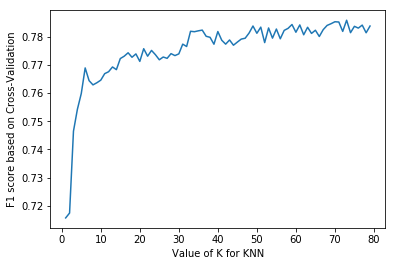

In [263]:
plt.plot(k_range, means)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 score based on Cross-Validation')
plt.show()

In [264]:
print(knn_grid_search_cv.best_score_)
print(knn_grid_search_cv.best_params_)
print(knn_grid_search_cv.best_estimator_)

0.7858752733361751
{'n_neighbors': 73}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=73, p=2,
           weights='uniform')


In [265]:
y_pred = knn_grid_search_cv.predict(X_test_scaled)
print("k-Nearest Neighbors classification results")
print("\n F1-Score \n", metrics.f1_score(y_test, y_pred))
print("\n Precision \n", metrics.precision_score(y_test, y_pred))
print("\n Recall \n", metrics.recall_score(y_test, y_pred))
print("\n Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))

k-Nearest Neighbors classification results

 F1-Score 
 0.7919911012235819

 Precision 
 0.8146453089244852

 Recall 
 0.7705627705627706

 Confusion Matrix 
 [[502  81]
 [106 356]]
